In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact

# 0 - State Variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

# 1 - Process Model & Q 

In [2]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [3]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), skew(x), axis=1)    # -skew(p) ???
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
                            # -u is the velocity of base (frame) under fixed-world frame, if so, we should fix this and unify the frame
                            # u is actually the velocity of fixed contact point under whisker base frame
    return prior_

In [4]:
# Process Noise
Q = np.array([[.001, 0, 0], [0, .001, 0], [0, 0, .00001]])

# 2 - Measurement Model & R

In [5]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [6]:
import pandas as pd

dataframe_x = pd.read_excel("data/0-CalibrationData/01031411/FullRangeData_x.xlsx", sheet_name="OnlyWithLeftside")
dataframe_y = pd.read_excel("data/0-CalibrationData/01031411/FullRangeData_y.xlsx", sheet_name="Formated_MannulyFixed")

# dataframe_y = pd.read_excel("data/0-CalibrationData/FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")

zx = np.array(dataframe_x)[:, 2]
zy = np.array(dataframe_y)[:, 2]

x = np.linspace(5, 95, 19)
y = np.linspace(115, 160, 10)

coeff_x, r_x, rank_x, s_x = polyfit2d(np.linspace(50, 95, 10), y, zx, kx=3, ky=3)
coeff_y, r_y, rank_y, s_y = polyfit2d(x, y, zy)

(100, 16) (100,)
(190, 36) (190,)


In [7]:
from sklearn.metrics import r2_score

print("Fitted results on X-axis of magentic flux measurement: ")

fitted_surf_x = np.polynomial.polynomial.polygrid2d(np.linspace(50, 95, 10), y, coeff_x.reshape((4, 4)))

rms_x = np.sqrt(np.mean((zx.reshape(10, 10).T - fitted_surf_x) ** 2))
print("RMS residual =", rms_x)
score_x = r2_score(zx.reshape(10, 10).T, fitted_surf_x)
print("R-squared value =", score_x)

print("Fitted results on Y-axis of magentic flux measurement: ")

fitted_surf_y = np.polynomial.polynomial.polygrid2d(x, y, coeff_y.reshape((6, 6)))

rms_y = np.sqrt(np.mean((zy.reshape(10, 19).T - fitted_surf_y) ** 2))
print("RMS residual =", rms_y)
score_y = r2_score(zy.reshape(10, 19).T, fitted_surf_y)
print("R-squared value =", score_y)

Fitted results on X-axis of magentic flux measurement: 
RMS residual = 0.029384329024556063
R-squared value = 0.9892038347077186
Fitted results on Y-axis of magentic flux measurement: 
RMS residual = 0.2117464176589923
R-squared value = 0.9806014352239169


### Measurement Model Plot 2D & 3D

(10, 10)


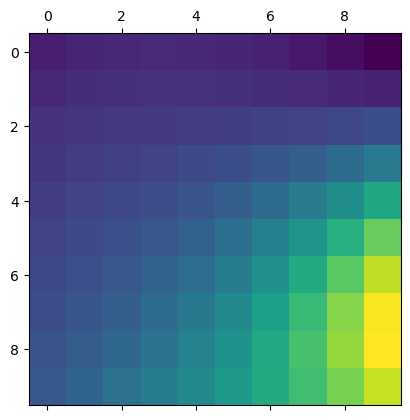

In [8]:
print(fitted_surf_x.shape)
plt.matshow(fitted_surf_x)

(19, 10)


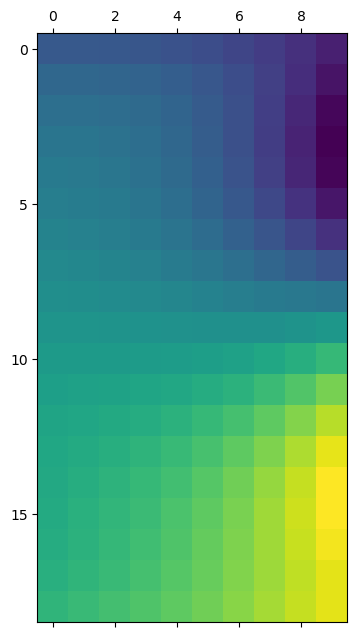

In [9]:
print(fitted_surf_y.shape)
plt.matshow(fitted_surf_y)

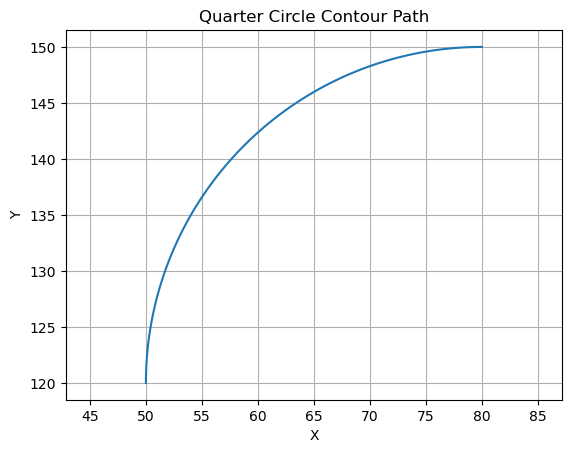

In [10]:
# Define start and end points
x_fic_start = 50
x_fic_end = 80
y_fic_start = 120
y_fic_end = 150

# Calculate center of the circle
center_x = x_fic_end
center_y = y_fic_start

# Calculate radius of the circle
radius = x_fic_end - x_fic_start

# Generate circle path
theta = np.linspace(np.pi, np.pi/2, 100)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)

# Plot circle
plt.plot(circle_x, circle_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quarter Circle Contour Path')
plt.grid(True)
plt.axis('equal')
plt.show()

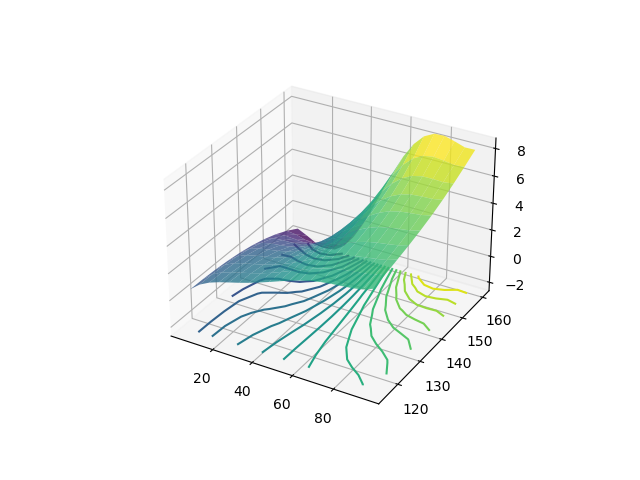

In [11]:
%matplotlib widget

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surf = ax.plot_surface(X, Y, fitted_surf_y.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(fitted_surf_y), np.max(fitted_surf_y), num_levels)
contour_surf = ax.contour(X, Y, fitted_surf_y.T, levels=contour_levels, offset=np.min(fitted_surf_y), cmap='viridis')

plt.show()

In [12]:
# 1 dim : Magnetic_y
def h_contact(x):
    h_y = np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff_y.reshape((6, 6)))
    return h_y

# 2 dim : Magnetic_x, Magnetic_y
# def h_contact(x):
#     h_x = np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff_x.reshape((4, 4)))
#     h_y = np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff_y.reshape((6, 6)))
#     return np.array([h_x, h_y])

In [13]:
# Test : Single Point
x_1 = np.array([65, 126, 0])
x_2 = np.array([98, 150, 0])
print(h_contact(x_1), h_contact(x_2))

4.233688951882836 7.261476209190139


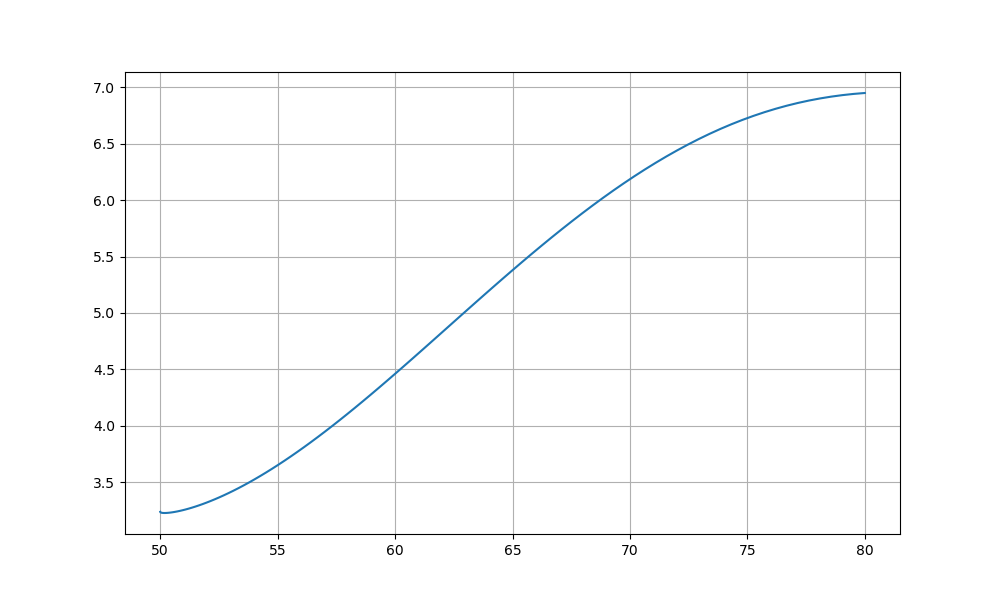

In [14]:
# Test : A quarter circle path
z_fic = np.polynomial.polynomial.polyval2d(circle_x[:], circle_y[:], coeff_y.reshape((6, 6)))

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(circle_x[:], z_fic[:])

In [15]:
# Measurement Noise

# 1 dim : Magnetic_y
R = np.array([[rms_y**2]])

# 2 dim : Magnetic_x, Magnetic_y
# R = np.array([[rms_x**2, 0], [0, rms_y**2]])

# 3 -  Data Preprocess

In [16]:
# Data format : 
#           timestamp，
#           magnetic_x, magnetic_y, magnetic_z, 
#           lv_x, lv_y, lv_z, av_x, av_y. av_z

trajectory_df = pd.read_csv("data/D_Cir_250HZ_6_2/trajectory.csv")

In [17]:
# delta time : second s

from datetime import datetime

dt_frame = np.array(trajectory_df)[:, 0]

dt = [0]
for i in range(1, dt_frame.shape[0]):
    tr = datetime.fromtimestamp(dt_frame[i])
    tf = datetime.fromtimestamp(dt_frame[i-1])
    dt.append((tr-tf).total_seconds())
dt = np.array(dt)

In [18]:
# linear- and angular-veolocity : mm/s & rad/s 

# be careful of coordinate frame translation !!!

# This is a normal velocity setting for plane and fixed contact point situation. The contact motion should be quite predictable
linear_vel = np.array([np.array(trajectory_df)[:, 5], -np.array(trajectory_df)[:, 6], np.array(trajectory_df)[:, 4]]) * 1e3
angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

# What if it is a circle or other convex contour? The contact point shall continuely move along the surface and its velocity could be hard to predict solely based on the velocity of whisker sensor.
# linear_vel = np.array([np.array(trajectory_df)[:, 5], np.array(trajectory_df)[:, 5], np.array(trajectory_df)[:, 4]]) * 1e3
# angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

us = np.append(linear_vel, angular_vel, axis=0).T

In [19]:
# Measurements Update : magnetic_y
zs = [np.array([np.array(trajectory_df)[i, 2]]) for i in range(trajectory_df.shape[0])]

# 4 - UKF with Fading Memory

In [20]:
# Initial estimate

x_initial = np.array([50, 115, 0])

In [21]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=1, fx=f_contact,
          hx=h_contact, dt=None, points=sigmas)

ukf.x = x_initial
ukf.R = R
ukf.Q = Q

# Introduce adaptive fading memory filter to compensate the error from dynamic contact 
ukf.alpha = 1.004

In [22]:
ukf

UnscentedKalmanFilter object
x = [ 50 115   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-03 0.e+00 0.e+00]
     [0.e+00 1.e-03 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.04483655]]
S = [[0.]]
K = [[0. 0. 0.]].T
y = [0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0. 0. 0. 0. 0.]].T
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual_z = <ufunc 'subtract'>
msqrt = <function cholesky at 0x0000022E3EDEFA60>
hx = <function h_contact at 0x0000022E4026DA60>
fx = <function f_co

# 5 - Test

In [23]:
uxs = []
for _ in range(len(zs)):
    ukf.predict(u=us[_], dt=dt[_])
    ukf.update(zs[_])
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

In [24]:
uxs.shape

(11092, 3)

In [25]:
from kf_book.book_plots import IntSlider

print(uxs)

def interactive_estimatesonbase(iter):

    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure(figsize=(10, 6))

    plt.grid()
    plt.ylim([115, 160])
    plt.xlim([0, 100])
    plt.plot(uxs[0:iter, 0], uxs[0:iter, 1], label='Estimated Trajectory')
    plt.scatter(uxs[iter-1, 0], uxs[iter-1, 1], marker='o', c='#d62728')
    plt.show()

interact(interactive_estimatesonbase, iter=IntSlider(value=1, min=0, max=uxs.shape[0]))

[[ 5.36975527e+01  1.14949935e+02  1.41772903e-16]
 [ 5.68837637e+01  1.15258242e+02 -2.63630702e-16]
 [ 5.97144668e+01  1.15847150e+02  1.88796679e-16]
 ...
 [ 7.50658394e+01  1.40221160e+02  3.56359484e-05]
 [ 7.50630309e+01  1.40236831e+02  3.54414474e-05]
 [ 7.50595490e+01  1.40256200e+02  3.49167087e-05]]


interactive(children=(IntSlider(value=1, continuous_update=False, description='iter', max=11092), Output()), _…

<function __main__.interactive_estimatesonbase(iter)>

### Dynamic contact results:

In [26]:
# set the first base frame position as the origin of fixed world frame

uxs_ = []
displacement = np.array([0. ,0. ,0.]) # overall position displacement from first iteration

for _ in range(uxs.shape[0]):
    displacement += np.dot(us[_][:3], dt[_])
    temp = uxs[_] + displacement
    uxs_.append(temp)
uxs_ = np.array(uxs_)

In [27]:
uxs_.shape

(11092, 3)

In [28]:
print(uxs_)

def interactive_estimatesonbase_dynamic(iter):

    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure(figsize=(10, 6))

    plt.grid()
    plt.ylim([115, 160])
    plt.xlim([0, 100])
    plt.plot(uxs_[:iter, 0], uxs_[:iter, 1], label='Estimated Trajectory')
    plt.scatter(uxs_[iter-1, 0], uxs_[iter-1, 1], marker='o', c='#d62728')
    plt.show()

interact(interactive_estimatesonbase_dynamic, iter=IntSlider(value=1, min=0, max=uxs.shape[0]))

[[ 5.36975527e+01  1.14949935e+02  1.41772903e-16]
 [ 5.69150437e+01  1.15289522e+02 -2.63630702e-16]
 [ 5.97667044e+01  1.15899388e+02  1.88796679e-16]
 ...
 [ 5.05929775e+01  1.15748298e+02  3.56359484e-05]
 [ 5.05901502e+01  1.15763951e+02  3.54414474e-05]
 [ 5.05866680e+01  1.15783319e+02  3.49167087e-05]]


interactive(children=(IntSlider(value=1, continuous_update=False, description='iter', max=11092), Output()), _…

<function __main__.interactive_estimatesonbase_dynamic(iter)>

### We shall check how the magnetic flux changed in the certain direction: y 

In [29]:
t = np.array(trajectory_df)[:, 0]
mag_x = np.array(trajectory_df)[:, 1]
mag_y = np.array(trajectory_df)[:, 2]
mag_z = np.array(trajectory_df)[:, 3]

print(np.min(mag_y), np.max(mag_y))

4.939999580383301 7.539999961853027


[1.70973937e+09 1.70973937e+09 1.70973937e+09 ... 1.70973941e+09
 1.70973941e+09 1.70973941e+09]
[6.5        6.5        6.62999964 ... 5.06999969 5.19999981 5.32999992]


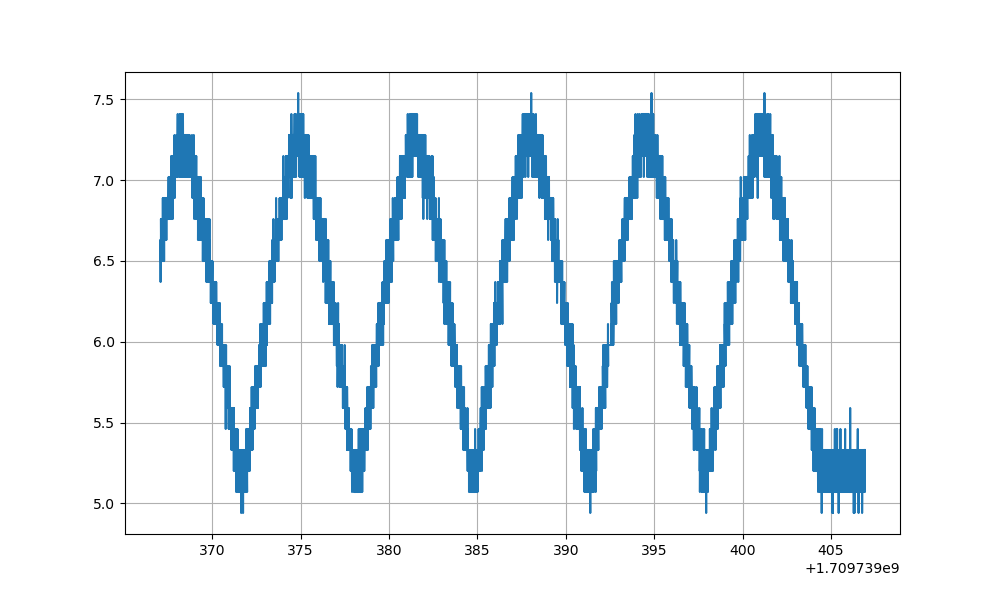

In [30]:
print(t)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_y[:], label='Magnetic Flux in Y-axis')

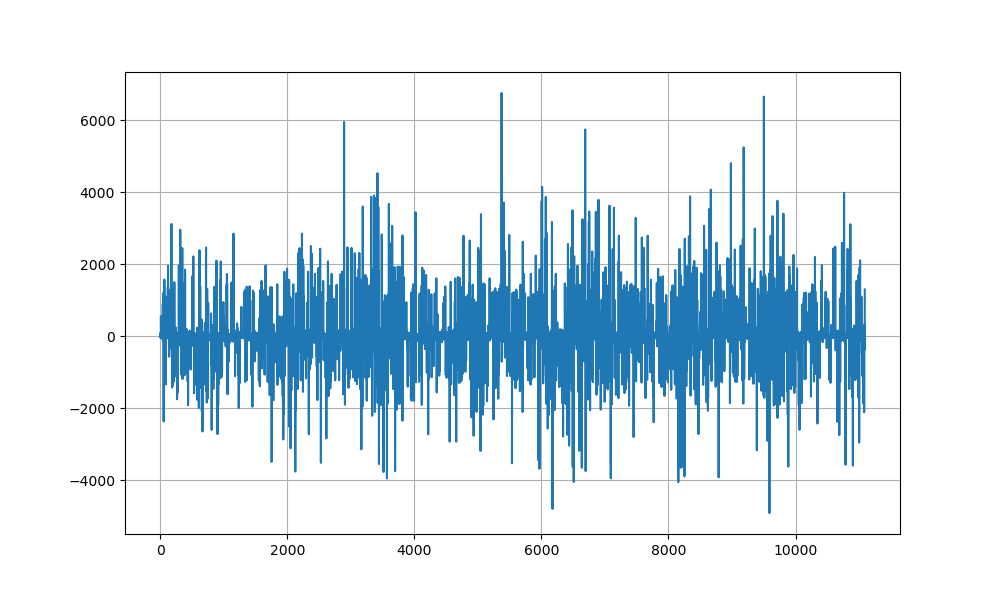

In [31]:
v_mag_y = []

for _ in range(1, t.shape[0]):
    d_t = t[_]-t[_-1]
    d_mag_y = mag_y[_]-mag_y[_-1]
    v_mag_y.append(d_mag_y/d_t)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(np.arange(0, len(v_mag_y), 1, dtype=int), v_mag_y[:], label='Magnetic Flux in Y-axis')

[1.70973937e+09 1.70973937e+09 1.70973937e+09 ... 1.70973941e+09
 1.70973941e+09 1.70973941e+09]
[-10.2699995  -10.2699995  -10.2699995  ... -10.78999996 -10.65999985
 -10.78999996]


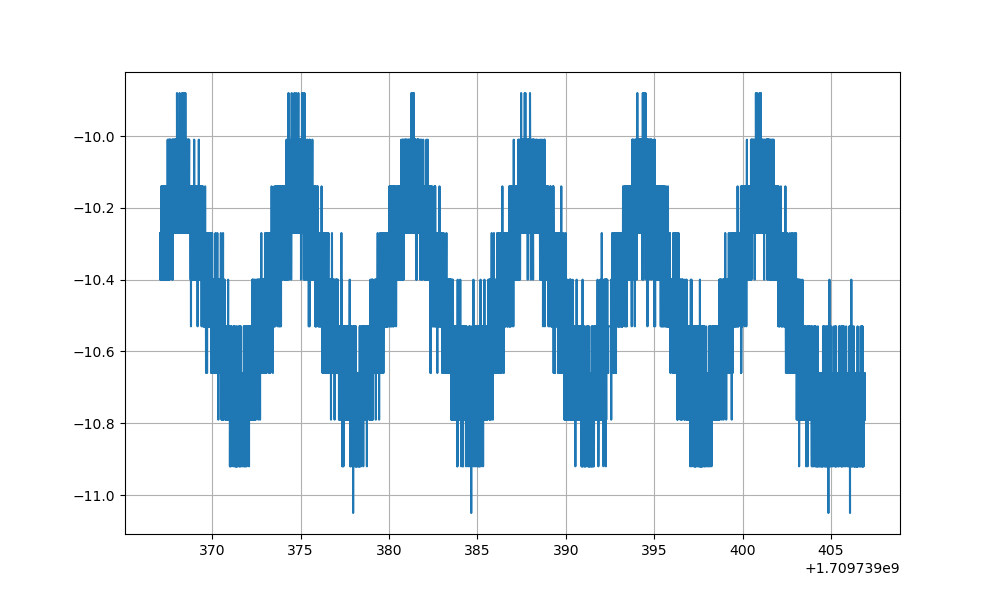

In [32]:
print(t)
print(mag_x)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_x[:], label='Magnetic Flux in Y-axis')

[-10.2699995  -10.2699995  -10.2699995  ... -10.78999996 -10.65999985
 -10.78999996]
[6.5        6.5        6.62999964 ... 5.06999969 5.19999981 5.32999992]


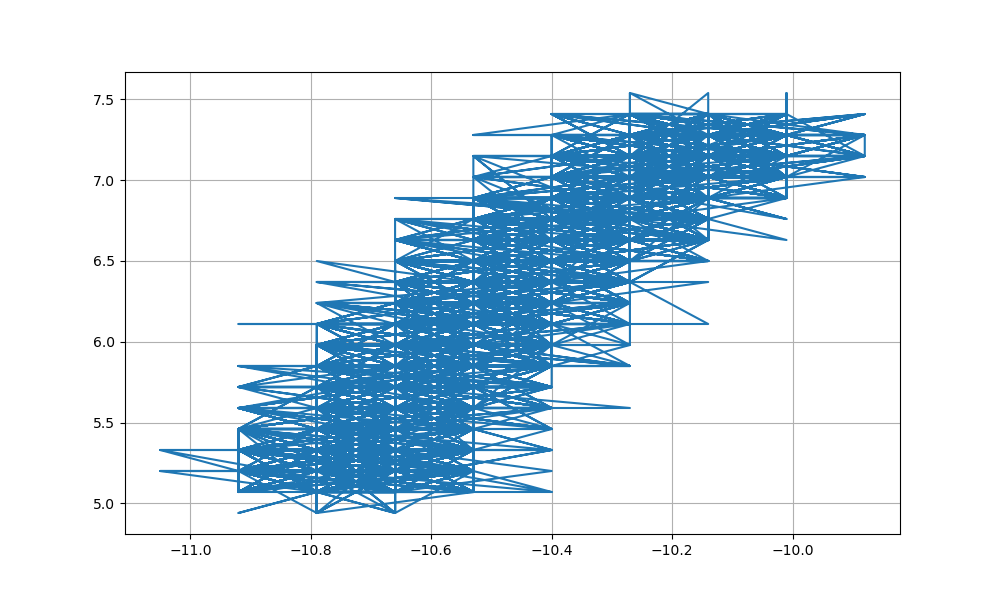

In [33]:
print(mag_x)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(mag_x[:], mag_y[:], label='Magnetic Flux in Y-axis')